<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use a trained model for inference

## Install IceVision
We usually install IceVision with `[all]`, but you can also use `[inference]` to only install the dependencies necessary for inference.

In [1]:
# !pip install icevision[all] icedata

## Imports

As always, import everything from IceVision:

In [2]:
from icevision.all import *

## Loading the model

We're going to use the model trained on the getting started tutorial.  

!!! info "Saving/Loading a model"  
    Save your model with `torch.save(model.state_dict(), PATH)`. Take a look at [this](https://pytorch.org/tutorials/beginner/saving_loading_models.html) tutorial for more info on how to save/load models.

The first thing we need is the `ClassMap` used during training. The model we're going to use was trained on the Pets dataset, so we can easily grab that:

In [3]:
class_map = icedata.fridge.class_map()

Recreate the model used in training:

In [4]:
from icedata.utils import load_model_weights_from_url

In [5]:
weights_url = 'https://github.com/airctic/model_zoo/releases/download/m2/fridge_tf_efficientdet_lite0.zip'
NUM_CLASSES = 5
model = efficientdet.model('tf_efficientdet_lite0', num_classes=NUM_CLASSES, img_size=512)
load_model_weights_from_url(model, weights_url)

/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


RuntimeError: Error(s) in loading state_dict for DetBenchTrain:
	size mismatch for anchors.boxes: copying a param with shape torch.Size([27621, 4]) from checkpoint, the shape in current model is torch.Size([49104, 4]).

In [6]:
model = icedata.fridge.trained_models.tf_efficientdet_lite0()

In [4]:
model = faster_rcnn.model(num_classes=len(class_map))

And now load the model weights (commonly refered as `state_dict` in Pytorch).  

In our case, the weights are stored in the cloud, Pytorch is amazing and provides us with a function to directly load model weights from an URL.

!!! info "Where to host your model"  
    You can save your model directly on github via a "release"  
    Simply go to `https://github.com/<ACCOUNT>/<REPO>/releases/new` and upload the model as a new release. This will generate a direct link for downloading the model.

In [5]:
WEIGHTS_URL = "https://github.com/airctic/model_zoo/releases/download/m3/pets_faster_resnetfpn50.zip"
state_dict = torch.hub.load_state_dict_from_url(WEIGHTS_URL, map_location=torch.device("cpu"))

If your weights are stored locally, you simply need to do: `state_dict = torch.load(<PATH>)`

!!! info "Model device"  
    Notice that we're asking to load the weights on CPU with `map_location`. It's common to do inference in CPU, but you can easily change to GPU if you want.

Now, let's actually load the weights to the model:

In [6]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Transforms

Generally speaking, we normally use on inference the same transforms we used in the validation set.  

A transform like `normalize` is always required, but for some models, a transform like `resize` is optional. For instance, the model used in this tutorial accepts any image resolution, try playing around with different transforms and observe how they change the model results.

Let's use the same transforms used in the validation set:

In [7]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=512), tfms.A.Normalize()])

## Data

Obviously we need some images to perform inference, how you get this images heavily depends on your use case.

For this tutorial, let's grab an image from an URL:

In [9]:
import PIL, requests
def image_from_url(url):
    res = requests.get(url, stream=True)
    img = PIL.Image.open(res.raw)
    return np.array(img)

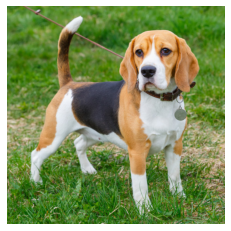

In [10]:
image_url = "https://petcaramelo.com/wp-content/uploads/2018/06/beagle-cachorro.jpg"
img = image_from_url(image_url)
show_img(img);

!!! info "Try it out"  
    Try experimenting with new images, be sure to take one of the breeds from `class_map` (or not, if you are curious to see what happens).

Whenever we have images in memory (numpy arrays) we can use `Dataset.from_images` to easily create a `Dataset` from it:

In [11]:
infer_ds = Dataset.from_images([img], infer_tfms)

## Predict - All at once

First build a batch with the entire dataset, and then simply call `predict`:

In [12]:
batch, samples = efficientdet.build_infer_batch(infer_ds)
# preds = efficientdet.predict(model=model, batch=batch)

In [13]:
ground_truth, preds = efficientdet.predict(model=model, dataset=infer_ds)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/effdet/bench.py", line 69, in _batch_detection
        img_scale_i = None if img_scale is None else img_scale[i]
        img_size_i = None if img_size is None else img_size[i]
        detections = generate_detections(
                     ~~~~~~~~~~~~~~~~~~~ <--- HERE
            class_out[i], box_out[i], anchor_boxes, indices[i], classes[i], img_scale_i, img_size_i)
        batch_detections.append(detections)
  File "/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/effdet/anchors.py", line 138, in generate_detections
    # Appply bounding box regression to anchors, boxes are converted to xyxy
    # here since PyTorch NMS expects them in that form.
    boxes = decode_box_outputs(box_outputs.float(), anchor_boxes, output_xyxy=True)
            ~~~~~~~~~~~~~~~~~~ <--- HERE
    if img_scale is not None and img_size is not None:
        boxes = clip_boxes_xyxy(boxes, img_size / img_scale)  # clip before NMS better?
  File "/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/effdet/anchors.py", line 134, in decode_box_outputs
    assert cls_outputs.shape[-1] == 1

    anchor_boxes = anchor_boxes[indices, :]
                   ~~~~~~~~~~~~~~~~~~~~~ <--- HERE

    # Appply bounding box regression to anchors, boxes are converted to xyxy
RuntimeError: index 48716 is out of bounds for dimension 0 with size 27621


## Predict - In batches

If the memory is not enough to predict everything at once, break it down into smaller batches with `infer_dataloader`:

In [ ]:
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

## Visualize

This step will probably not be the same for your use case, but for quickly visualizing the predictions we can use `show_preds`:

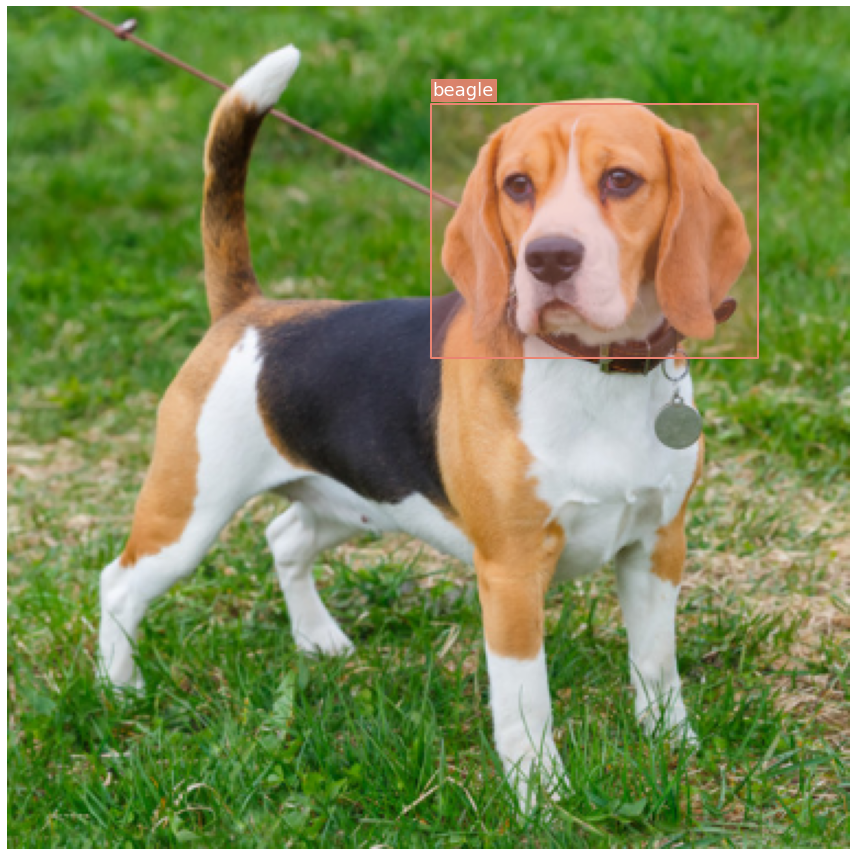

In [25]:
# Show preds by grabbing the images from `samples`
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)


## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).